<a href="https://colab.research.google.com/github/parasgulati8/Fake-News-Detection/blob/master/Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd drive/'My Drive'/'Colab Notebooks'/dataset

/content/drive/My Drive/Colab Notebooks/dataset


#Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout
import matplotlib.pyplot as plt
import os

In [29]:
from tensorflow.keras.utils import plot_model

# Train on labelled data

In [ ]:
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake['Text'] = (fake.title +'. ' + fake.text)
true['Text'] = true.title + '. ' + true.text

In [ ]:
fake['label'] = 0
true['label'] = 1

In [ ]:
true.head()

,title,text,subject,date,Text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017","As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Trump wants Postal Service to charge 'much mor...,1


In [ ]:
news = pd.concat([true.iloc[:, 4:], fake.iloc[:, 4:]])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

In [ ]:
for train_index, test_index in sss.split(news.Text, news.label):
     print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = news.iloc[train_index, 0], news.iloc[test_index, 0]
     y_train, y_test = news.iloc[train_index, 1], news.iloc[test_index, 1]

TRAIN: [25362 23734 28153 ... 34226 35226 29567] TEST: [37029 43919  6641 ... 29966 29894  1702]


In [ ]:
print(X_train.shape, X_test.shape)

(35918,) (8980,)


In [ ]:
max([len(i) for i in X_train])

51894

In [ ]:
min([len(i) for i in X_train])

32

In [ ]:
sum([len(i) for i in X_train])/len(X_train)

2545.213541956679

In [ ]:
np.median([len(i) for i in X_train])

2269.5

In [ ]:
np.median([len(i) for i in X_test])

2278.0

In [ ]:
max_features = 10000
maxlen = 300

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
EMBEDDING_FILE = 'glove.twitter.27B.100d.txt'

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
batch_size = 256
epochs = 100
embed_size = 100

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Epoch 1/100
141/141 [==============================] - 10s 72ms/step - loss: 0.2775 - accuracy: 0.8899 - val_loss: 0.2388 - val_accuracy: 0.9049
Epoch 2/100
141/141 [==============================] - 9s 67ms/step - loss: 0.1515 - accuracy: 0.9455 - val_loss: 0.1533 - val_accuracy: 0.9452
Epoch 3/100
141/141 [==============================] - 9s 67ms/step - loss: 0.1600 - accuracy: 0.9425 - val_loss: 0.2835 - val_accuracy: 0.9144
Epoch 4/100
141/141 [==============================] - 9s 67ms/step - loss: 0.1296 - accuracy: 0.9565 - val_loss: 0.1168 - val_accuracy: 0.9588
Epoch 5/100
141/141 [==============================] - 9s 67ms/step - loss: 0.1381 - accuracy: 0.9541 - val_loss: 0.0907 - val_accuracy: 0.9714
Epoch 6/100
141/141 [==============================] - 9s 67ms/step - loss: 0.0967 - accuracy: 0.9693 - val_loss: 0.0973 - val_accuracy: 0.9699
Epoch 7/100
141/141 [==============================] - 9s 67ms/step - loss: 0.0714 - accuracy: 0.9776 - val_loss: 0.0564 - val_accuracy

In [ ]:
len(epochs)

10

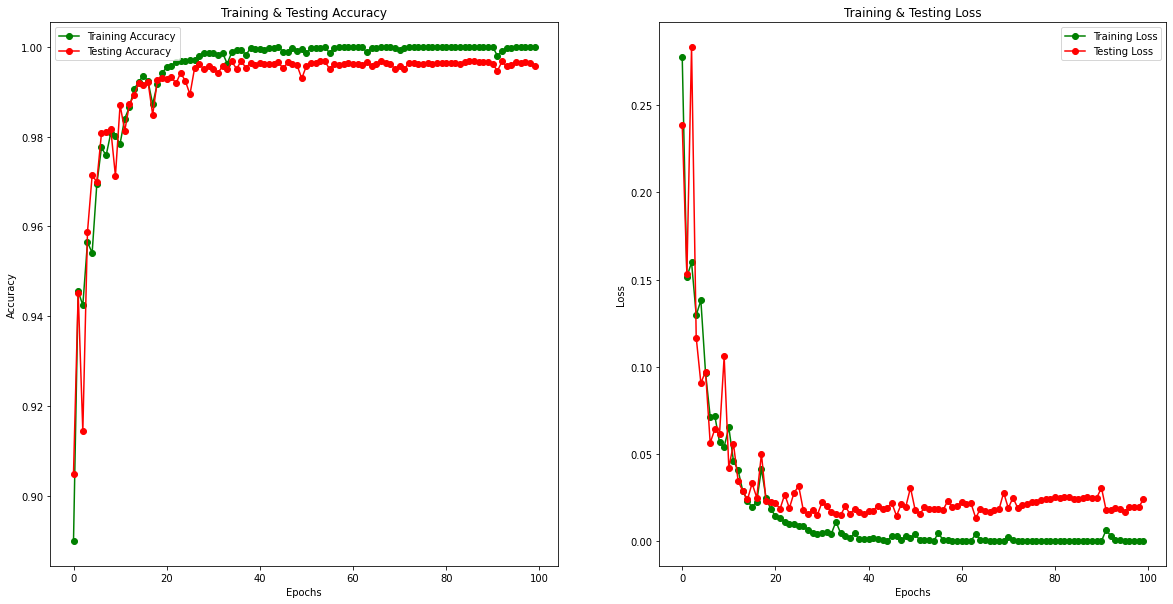

In [ ]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
import os

In [ ]:
save_path = os.path.join("model/")
tf.saved_model.save(model, save_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


In [ ]:
ls model/variables  

variables.data-00000-of-00002  variables.data-00001-of-00002  variables.index


# Loading the model for evaluating it 

In [ ]:
fake = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/Fake.csv')
true = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/True.csv')

fake['Text'] = (fake.title +'. ' + fake.text)
true['Text'] = true.title + '. ' + true.text

fake['label'] = 0
true['label'] = 1

news = pd.concat([true.iloc[:, 4:], fake.iloc[:, 4:]])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(news.Text, news.label):
     print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = news.iloc[train_index, 0], news.iloc[test_index, 0]
     y_train, y_test = news.iloc[train_index, 1], news.iloc[test_index, 1]

max_features = 10000
maxlen = 300

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(tokenized_train, maxlen=maxlen)

TRAIN: [25362 23734 28153 ... 34226 35226 29567] TEST: [37029 43919  6641 ... 29966 29894  1702]


In [ ]:
X_test = pd.read_csv('Cure tagged- sample.csv', encoding = "utf-8")['tweet']
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/dataset/model')

In [ ]:
y_pred = new_model.predict(X_test)

In [ ]:
y_pred = pd.DataFrame(y_pred)

In [ ]:
y_pred.to_csv('Predictions.csv')

In [ ]:
loss, acc = new_model.evaluate(X_test,  np.array([0]*len(X_test)), verbose=2, )
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

# print(new_model.predict(test_images).shape)

56/56 - 2s - loss: 0.0127 - accuracy: 0.9989
Restored model, accuracy: 99.89%


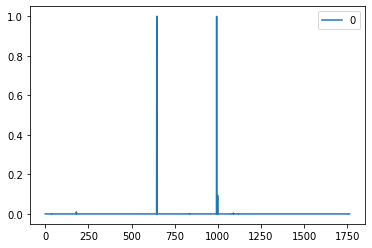

In [ ]:
(y_pred).plot()

# Running Saved Model on huge Data

In [30]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/dataset/model')

In [3]:
fake = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/Fake.csv')
true = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/True.csv')

fake['Text'] = (fake.title +'. ' + fake.text)
true['Text'] = true.title + '. ' + true.text

fake['label'] = 0
true['label'] = 1

news = pd.concat([true.iloc[:, 4:], fake.iloc[:, 4:]])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(news.Text, news.label):
     print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = news.iloc[train_index, 0], news.iloc[test_index, 0]
     y_train, y_test = news.iloc[train_index, 1], news.iloc[test_index, 1]

max_features = 10000
maxlen = 300

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(tokenized_train, maxlen=maxlen)

TRAIN: [25362 23734 28153 ... 34226 35226 29567] TEST: [37029 43919  6641 ... 29966 29894  1702]


In [2]:
cd /content/drive/My Drive/Colab Notebooks/Datathon

/content/drive/My Drive/Colab Notebooks/Datathon


In [9]:
X_test = []
for file in os.listdir():
  X_test_ = pd.read_csv(file, encoding = "utf-8")['tweet']
  tokenized_test = tokenizer.texts_to_sequences(X_test_)
  X_test_ = pad_sequences(tokenized_test, maxlen=maxlen)
  X_test.append(X_test_)

In [16]:
x = np.array(X_test[0])
for i in X_test[1:]:
  x = np.vstack((x, i))

In [24]:
y_pred = new_model.predict(x)

In [25]:
np.savez_compressed('y_pred.npz', y_pred = y_pred)

In [6]:
data = pd.DataFrame(columns=['Tweet'])
for file in os.listdir()[:-1]:
  print(file)
  tweet = pd.read_csv(file, encoding = "utf-8")['tweet']
  data = pd.concat([data, tweet])

conspiracy_theories__US April 03, 2020 0240 PM - April 04, 2020 1154 AM.csv
conspiracy_theories__US April 07, 2020 1229 PM - April 08, 2020 1234 PM.csv
conspiracy_theories__US April 06, 2020 1058 AM - April 07, 2020 1228 PM.csv
cure__US April 06, 2020 1058 AM - April 07, 2020 1228 PM.csv
cure__US April 05, 2020 1256 PM - April 06, 2020 1057 AM.csv
cure__US April 01, 2020 1102 AM - April 02, 2020 1219 PM.csv
cure__US March 20, 2020 0949 PM - March 21, 2020 0925 AM.csv
emergency_measures__US GeoLocation_april28-may14.csv
good_news__US April 03, 2020 0240 PM - April 04, 2020 1154 AM.csv
emergency_measures__US March 20, 2020 0949 PM - March 21, 2020 0925 AM.csv
good_news__US April 06, 2020 1058 AM - April 07, 2020 1228 PM.csv
good_news__US April 04, 2020 1156 AM - April 05, 2020 1254 PM.csv
good_news__US April 07, 2020 1229 PM - April 08, 2020 1234 PM.csv
misbehaviour_scams__US April 01, 2020 1102 AM - April 02, 2020 1219 PM.csv
nature_of_virus__US April 07, 2020 1229 PM - April 08, 2020 1

In [8]:
y_pred = np.load('y_pred.npz')
y_pred = y_pred['y_pred']

In [11]:
data['probability_od_news_being_true'] = y_pred

In [17]:
data = data.drop(columns=['Tweet'])
data = data.rename(columns={0:'Tweet'})

In [25]:
data.head()

,Tweet,probability_od_news_being_true
0,"Find them internet, plenty of corona virus in ...",1.367184e-06
1,The Mexican brewer of Corona beer says it is s...,1.045658e-06
2,"While @POTUS was delivering the SOTU, talking...",2.057727e-06
3,India should be grateful to Corona for exposin...,1.325684e-05
4,Florida man and pastor tries to give Jesus and...,8.899410e-07


In [26]:
data.to_csv('fake_news_predictions.csv')

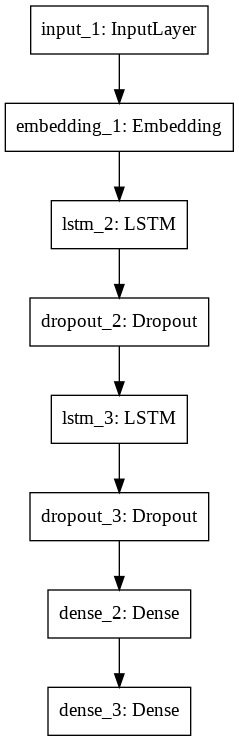

In [31]:
plot_model(new_model)

In [28]:
pwd

'/content/drive/My Drive/Colab Notebooks/Datathon'